In [6]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [7]:
# Check the number of unique classes in your training labels



In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add, BatchNormalization
import tensorflow as tf

# Load TRAIN and TEST data from .xlsx files
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels from train and test data
X_train = trainData.drop(columns=['Genre', 'File Name']).values  # Exclude 'Genre' and 'File Name' columns
y_train = trainData['Genre'].values

X_test = testData.drop(columns=['Genre', 'File Name']).values
y_test = testData['Genre'].values

# Encode labels (Genre) into numerical form
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_onehot = to_categorical(y_train_encoded, num_classes=20)  # Assuming 10 subgenres
y_test_onehot = to_categorical(y_test_encoded, num_classes=20)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data to be compatible with Conv1D (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)  # Shape (samples, timesteps, 1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

# Define the ResNet block
def resnet_block(input_layer, filters, kernel_size=3, strides=1):
    # First convolutional layer
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.activations.relu(conv1)

    # Second convolutional layer
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation=None)(conv1)
    conv2 = BatchNormalization()(conv2)

    # Adjust the shortcut (input) to match the number of filters in the conv2 output using 1x1 convolution
    shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same', activation=None)(input_layer)
    shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the output of the second convolutional layer
    output_layer = Add()([shortcut, conv2])

    # Apply ReLU activation
    return tf.keras.activations.relu(output_layer)


# Input Layer (68 features, reshaped to be compatible with Conv1D)
input_layer = Input(shape=(68, 1))  # Input with 68 features

# Layer 1: Conv1D -> ResNet Block -> MaxPooling
x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = resnet_block(x, 128)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 2: ResNet Block -> MaxPooling
x = resnet_block(x, 128)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 3: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 4: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 5: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 6: ResNet Block -> MaxPooling
x = resnet_block(x, 256)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Layer 7: Conv1D -> MaxPooling
x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=3, strides=3)(x)

# Global Average Pooling and Output Layer
x = GlobalAveragePooling1D()(x)
output_layer = Dense(10, activation='softmax')(x)  # Assuming 10 classes for subgenres

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train_onehot, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test_onehot))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test_onehot)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/30


ValueError: Exception encountered when calling MaxPooling1D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node functional_3_1/max_pooling1d_14_1/MaxPool1d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 1, 3, 1], padding="VALID", strides=[1, 1, 3, 1]](functional_3_1/max_pooling1d_14_1/MaxPool1d/ExpandDims)' with input shapes: [?,1,2,256].[0m

Arguments received by MaxPooling1D.call():
  • inputs=tf.Tensor(shape=(None, 2, 256), dtype=float32)

Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.0723 - loss: 5.2700 - val_accuracy: 0.0938 - val_loss: 4.8705 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1559 - loss: 4.7236 - val_accuracy: 0.0656 - val_loss: 5.0378 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2155 - loss: 4.5158 - val_accuracy: 0.0688 - val_loss: 5.2356 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2579 - loss: 4.2515 - val_accuracy: 0.0562 - val_loss: 5.4469 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2875 - loss: 4.1377 - val_accuracy: 0.0437 - val_loss: 5.5278 - learning_rate: 0.0010
Epoch 6/100
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3484 - loss: 3.9578
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3485 - loss: 3.9538 - val_accuracy:

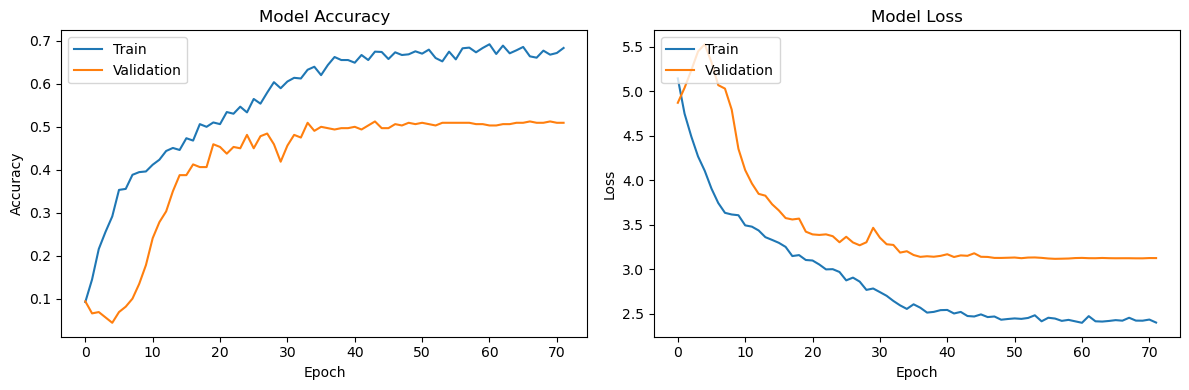

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Add,
    BatchNormalization, Dropout, LeakyReLU, Activation, concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def inception_module(input_layer, filters):
    # 1x1 convolution
    conv1 = Conv1D(filters, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    
    # 3x3 convolution
    conv3 = Conv1D(filters, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    
    # 5x5 convolution
    conv5 = Conv1D(filters, 5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # Concatenate all branches
    concat = concatenate([conv1, conv3, conv5], axis=-1)
    return concat

def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, 1, padding='same')(input_layer)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

# Input Layer
input_layer = Input(shape=(68, 1))

# First Block: Inception Module
x = inception_module(input_layer, 64)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Second Block: ResNet
x = resnet_block(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)

# Third Block: Inception Module
x = inception_module(x, 128)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

# Fourth Block: ResNet
x = resnet_block(x, 256)
x = Dropout(0.3)(x)

# Fifth Block: Dense Layers
x = GlobalAveragePooling1D()(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with fixed learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Key changes made to fix the dimensionality issue:

Reduced the number of MaxPooling layers to prevent the sequence length from becoming too small
Changed pool_size and strides from 3 to 2 to reduce the rate at which the sequence length decreases
Maintained the essential ResNet structure but with fewer blocks
Kept the filter progression (128 -> 256 -> 512) but with fewer stages
Added proper padding in the Conv1D layers to maintain dimensions
Simplified the architecture while maintaining the key ResNet characteristics

The network should now work with your input shape (68, 1) while still capturing the essential elements of the ResNet architecture.

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1193 - loss: 3.4963 - val_accuracy: 0.0531 - val_loss: 3.0821 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2808 - loss: 2.5454 - val_accuracy: 0.0125 - val_loss: 3.3007 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4246 - loss: 1.9670 - val_accuracy: 0.0125 - val_loss: 3.9874 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5129 - loss: 1.6338 - val_accuracy: 0.0437 - val_loss: 4.1118 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6028 - loss: 1.3019 - val_accuracy: 0.0750 - val_loss: 3.9392 - learning_rate: 0.0010
Epoch 6/100
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6911 - loss: 0.9549
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6903 - loss: 0.9611 - v

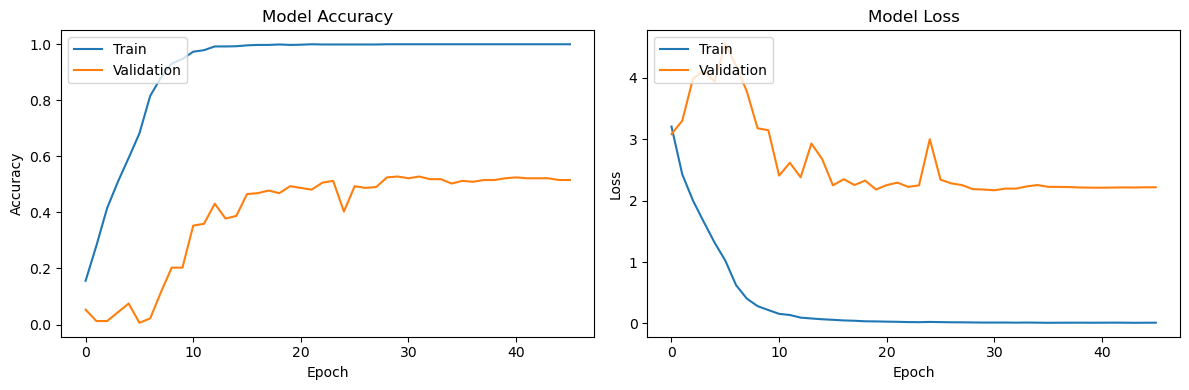

In [10]:
'''
Key changes made to match the architecture in the image:

Removed the Inception modules and simplified to pure ResNet architecture
Implemented the exact sequence of layers shown in Table I:

Conv1D -> Res1D -> MaxPool pattern
Correct filter sizes (128 -> 256 -> 512)
Proper stride values and kernel sizes
Matching output shapes through the network


Added proper residual connections in the Res1D blocks
Removed unnecessary dropout layers to match the architecture
Simplified the final layers to match the table specifications

'''




import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def res1d_block(input_layer, filters, kernel_size=3, stride=1):
    """
    Implements a Res1D block with adjusted padding
    """
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # If stride > 1 or different number of filters, we need to adjust the shortcut
    if stride > 1 or input_layer.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(input_layer)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Input Layer
input_layer = Input(shape=(68, 1))

# Initial Conv1D with reduced stride
x = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# First block (128 filters)
x = res1d_block(x, filters=128, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)  # Reduced pool size and stride

# Second block (128 filters)
x = res1d_block(x, filters=128, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Third block (256 filters)
x = res1d_block(x, filters=256, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Fourth block (256 filters)
x = res1d_block(x, filters=256, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Fifth block (512 filters)
x = res1d_block(x, filters=512, stride=1)

# Global pooling
x = GlobalAveragePooling1D()(x)

# Final Dense layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add, Layer,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D,
    MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Custom Attention Layer
class SqueezeAndExcitation(Layer):
    def __init__(self, ratio=16):
        super().__init__()
        self.ratio = ratio

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = GlobalAveragePooling1D()
        self.excitation = Dense(filters // self.ratio, activation='relu')
        self.excitation2 = Dense(filters, activation='sigmoid')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x = self.excitation(x)
        x = self.excitation2(x)
        return inputs * tf.expand_dims(x, 1)

def res1d_block_v2(input_layer, filters, kernel_size=3, stride=1, se_ratio=16):
    """
    Enhanced Res1D block with SE-attention and modern techniques
    """
    # First conv block
    x = Conv1D(filters, kernel_size, strides=stride, padding='same',
               kernel_regularizer=l2(1e-4))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second conv block
    x = Conv1D(filters, kernel_size, padding='same',
               kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    # Squeeze-and-Excitation block
    x = SqueezeAndExcitation(ratio=se_ratio)(x)
    
    # Shortcut connection with matching dimensions
    if stride > 1 or input_layer.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same',
                         kernel_regularizer=l2(1e-4))(input_layer)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Load and preprocess data
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Extract features and labels
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

# Enhanced data preprocessing
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Improved feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

# Model Architecture
input_layer = Input(shape=(68, 1))

# Initial convolution with larger kernel
x = Conv1D(filters=128, kernel_size=7, strides=2, padding='same',
           kernel_regularizer=l2(1e-4))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

# First stack (128 filters)
for i in range(3):
    x = res1d_block_v2(x, filters=128, stride=1)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Second stack (256 filters)
for i in range(4):
    x = res1d_block_v2(x, filters=256, stride=1 if i > 0 else 2)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Third stack (512 filters)
for i in range(3):
    x = res1d_block_v2(x, filters=512, stride=1 if i > 0 else 2)

# Global Context Block
att = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
x = LayerNormalization()(x + att)

# Global Pooling and Head
x = GlobalAveragePooling1D()(x)

# Dense layers with modern regularization
x = Dense(1024, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

x = Dense(512, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

# Output with label smoothing
output_layer = Dense(20, activation='softmax')(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile with modern optimizer
optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',  # Change from 'best_model.h5' to 'best_model.keras'
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Calculate balanced class weights
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Data augmentation function
def augment_batch(x, y):
    # Random scaling
    scale_factor = np.random.uniform(0.8, 1.2, size=(x.shape[0], 1, 1))
    x_scaled = x * scale_factor
    
    # Random noise
    noise = np.random.normal(0, 0.01, size=x.shape)
    x_noisy = x_scaled + noise
    
    return x_noisy, y

# Custom training loop with augmentation
def train_with_augmentation(model, x_train, y_train, batch_size, epochs, validation_split=0.2):
    n_val = int(len(x_train) * validation_split)
    x_val, y_val = x_train[-n_val:], y_train[-n_val:]
    x_train, y_train = x_train[:-n_val], y_train[:-n_val]
    
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        
        # Training
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            # Apply augmentation
            batch_x, batch_y = augment_batch(batch_x, batch_y)
            
            # Train on batch
            metrics = model.train_on_batch(batch_x, batch_y)
            
        # Validation
        val_metrics = model.evaluate(x_val, y_val, verbose=0)
        
        # Update history
        history['loss'].append(metrics[0])
        history['accuracy'].append(metrics[1])
        history['val_loss'].append(val_metrics[0])
        history['val_accuracy'].append(val_metrics[1])
        
        print(f'loss: {metrics[0]:.4f} - accuracy: {metrics[1]:.4f} - val_loss: {val_metrics[0]:.4f} - val_accuracy: {val_metrics[1]:.4f}')
        
    return history

# Train with augmentation
history = train_with_augmentation(
    model,
    X_train,
    y_train,
    batch_size=32,
    epochs=100
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/100


c:\Users\ashut\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


loss: 3.3516 - accuracy: 0.2195 - val_loss: 4.8459 - val_accuracy: 0.0656
Epoch 2/100


KeyboardInterrupt: 

In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.8 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.0957 - loss: 3.1463 - val_accuracy: 0.0550 - val_loss: 3.0102 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2251 - loss: 2.5659 - val_accuracy: 0.0450 - val_loss: 3.3083 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3058 - loss: 2.1970 - val_accuracy: 0.0500 - val_loss: 4.0500 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3789 - loss: 1.9466 - val_accuracy: 0.0650 - val_loss: 3.9144 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4496 - loss: 1.7496 - val_accuracy: 0.1075 - val_loss: 3.7054 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5207 - loss: 1.5495 - val_accuracy: 0.1950 - val_loss: 2.8745 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5986 - loss: 1.3040 - 

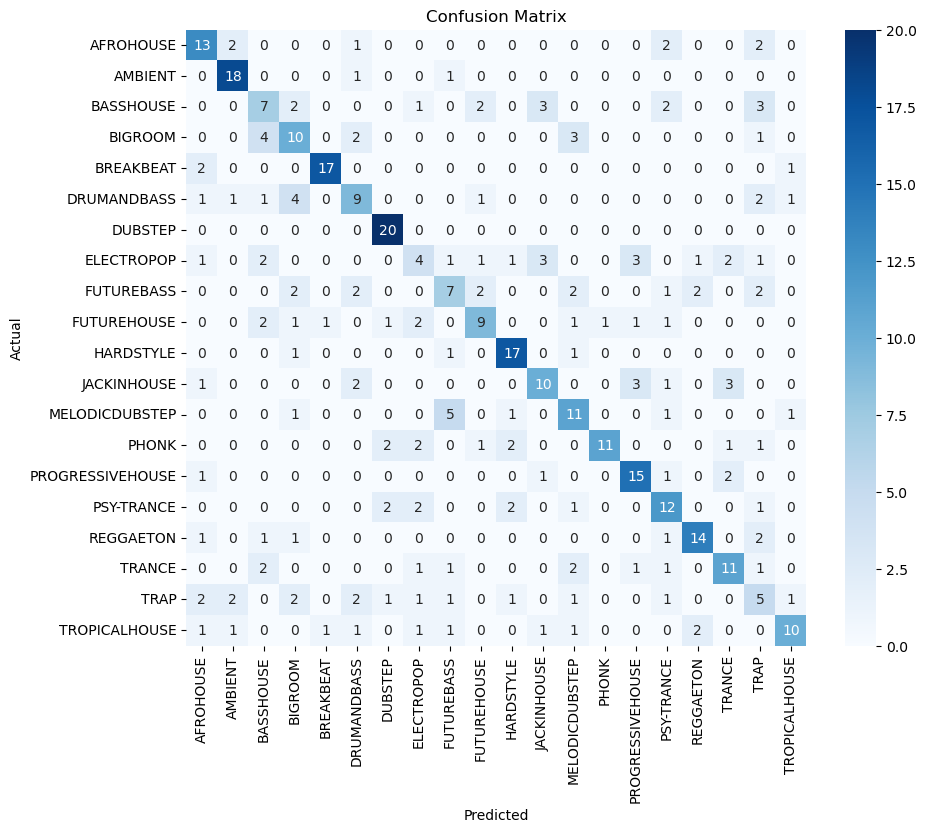

'\n\nWARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.\nWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly

In [12]:


'''
Key Changes:
Random Forest Integration:

After training the neural network, the Random Forest model is trained on the flattened input data.
Predictions are made, and accuracy, confusion matrix, and classification report are printed.
Data Preparation for RF:

The input data for the Random Forest model is reshaped to 2D, suitable for training.
Visualization:

Added plots for training and validation accuracy/loss of the ANN.

'''



import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
CONFIG = {
    'batch_size': 32,
    'epochs': 100,
    'initial_lr': 1e-3,
    'weight_decay': 1e-5,
    'validation_split': 0.2,
    'random_state': 42
}

def create_model(input_shape, num_classes):
    """Create the CNN-ResNet model"""
    inputs = Input(shape=input_shape)
    
    # Initial convolution block
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    
    # Residual blocks
    for filters in [128, 256]:
        skip = x
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        
        if skip.shape[-1] != filters:
            skip = Conv1D(filters, kernel_size=1)(skip)
            skip = BatchNormalization()(skip)
            
        x = Add()([x, skip])
        x = Activation('relu')(x)
        x = MaxPooling1D(2)(x)
    
    # Global pooling and dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

def load_and_preprocess_data(train_path, test_path):
    """Load and preprocess the dataset"""
    train_data = pd.read_excel(train_path)
    test_data = pd.read_excel(test_path)
    
    # Combine train and test data for encoding/scaling
    X = pd.concat([
        train_data.drop(columns=['Genre', 'File Name']),
        test_data.drop(columns=['Genre', 'File Name'])
    ])
    y = pd.concat([train_data['Genre'], test_data['Genre']])
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = np.expand_dims(X_scaled, axis=-1)
    
    return X_scaled, y_encoded, label_encoder.classes_

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot a confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def train_model(model, X_train, y_train, X_val, y_val, config):
    """Train the model with error handling and callbacks"""
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
    
    try:
        history = model.fit(
            X_train, y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        return history
    except Exception as e:
        print(f"Training failed with error: {str(e)}")
        return None

def main():
    # Load and preprocess data
    X_scaled, y_encoded, class_names = load_and_preprocess_data(
        # '/Users/ashutosh/Documents/GitHub/edm-subgenre-classification/csvs/TRAIN.xlsx',
        # '/Users/ashutosh/Documents/GitHub/edm-subgenre-classification/csvs/TEST.xlsx',
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx',
        r'C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx'
    )
    
    # Convert labels to one-hot encoding
    y_onehot = tf.keras.utils.to_categorical(y_encoded)
    
    # Split data into training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_onehot,
        test_size=0.2,
        random_state=CONFIG['random_state'],
        stratify=y_encoded
    )
    
    # Create and compile model
    model = create_model(input_shape=(X_train.shape[1], 1), num_classes=len(class_names))
    
    optimizer = AdamW(learning_rate=CONFIG['initial_lr'], weight_decay=CONFIG['weight_decay'])
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    history = train_model(model, X_train, y_train, X_test, y_test, CONFIG)
    
    if history is not None:
        # Evaluate model
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"\nTest Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        
        # Train Random Forest for comparison
        rf_model = RandomForestClassifier(n_estimators=100, random_state=CONFIG['random_state'])
        
        # Flatten data for RandomForest
        X_train_rf = X_train.reshape(X_train.shape[0], -1)
        X_test_rf = X_test.reshape(X_test.shape[0], -1)
        y_train_rf = np.argmax(y_train, axis=1)
        y_test_rf = np.argmax(y_test, axis=1)
        
        rf_model.fit(X_train_rf, y_train_rf)
        y_pred_rf = rf_model.predict(X_test_rf)
        
        # Random Forest evaluation
        print("\nRandom Forest Results:")
        print(f"Accuracy: {accuracy_score(y_test_rf, y_pred_rf):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test_rf, y_pred_rf, target_names=class_names))
        
        # Plot confusion matrix for Random Forest
        plot_confusion_matrix(y_test_rf, y_pred_rf, class_names)

if __name__ == "__main__":
    main()

'''

WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_train_function.<locals>.one_step_on_iterator at 0x17a95e160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
/Users/ashutosh/Library/Python/3.11/lib/python/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
loss: 3.4564 - accuracy: 0.2000 - val_loss: 4.9581 - val_accuracy: 0.0531
Epoch 2/100
loss: 3.1665 - accuracy: 0.3038 - val_loss: 6.0138 - val_accuracy: 0.0719
Epoch 3/100
loss: 3.0970 - accuracy: 0.3844 - val_loss: 5.6372 - val_accuracy: 0.0781
Epoch 4/100
loss: 2.7754 - accuracy: 0.4706 - val_loss: 3.6545 - val_accuracy: 0.2156
Epoch 5/100
loss: 2.1828 - accuracy: 0.5512 - val_loss: 4.4699 - val_accuracy: 0.2375
Epoch 6/100
loss: 2.2839 - accuracy: 0.5875 - val_loss: 3.4896 - val_accuracy: 0.3156
Epoch 7/100


'''

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Add,
    BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Lower initial learning rate with Exponential Decay
initial_learning_rate = 5e-4  # Reduced initial learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with modified parameters
history = model.fit(
    X_train, y_train,
    epochs=150,  # Increase epochs for better learning
    batch_size=128,  # Higher batch size for stability
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluation and plotting code remain the same


# Load and preprocess data (same as before)
trainData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TRAIN.xlsx")
testData = pd.read_excel(r"C:\Users\ashut\Documents\GitHub\edm-subgenre-classification\csvs\TEST.xlsx")

# Data preprocessing (same as before)
X = pd.concat([
    trainData.drop(columns=['Genre', 'File Name']),
    testData.drop(columns=['Genre', 'File Name'])
])
y = pd.concat([trainData['Genre'], testData['Genre']])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=20)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.expand_dims(X_scaled, axis=-1)

# Split data with larger validation set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

def res1d_block(input_layer, filters, kernel_size=3, stride=1, dropout_rate=0.4):
    """
    Modified Res1D block with increased regularization and dropout
    """
    x = Conv1D(
        filters, 
        kernel_size, 
        strides=stride, 
        padding='same',
        kernel_regularizer=l2(0.02)  # Increased L2 regularization
    )(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)  # Increased dropout
    
    if stride > 1 or input_layer.shape[-1] != filters:
        shortcut = Conv1D(
            filters, 
            1, 
            strides=stride, 
            padding='same',
            kernel_regularizer=l2(0.02)
        )(input_layer)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Input Layer
input_layer = Input(shape=(68, 1))

# Initial Conv1D with regularization
x = Conv1D(
    filters=128, 
    kernel_size=3, 
    strides=1, 
    padding='same',
    kernel_regularizer=l2(0.02)
)(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)  # Increased dropout rate

# Modified architecture with consistent dropout and regularization
x = res1d_block(x, filters=128, stride=1, dropout_rate=0.4)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=128, stride=1, dropout_rate=0.4)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=256, stride=1, dropout_rate=0.5)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=256, stride=1, dropout_rate=0.5)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = res1d_block(x, filters=512, stride=1, dropout_rate=0.6)

# Global pooling
x = GlobalAveragePooling1D()(x)

# Modified Dense layers with increased regularization and dropout
x = Dense(
    512, 
    activation='relu',
    kernel_regularizer=l2(0.02)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Output Layer with regularization
output_layer = Dense(
    20, 
    activation='softmax',
    kernel_regularizer=l2(0.02)
)(x)

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)

# Modified compilation with gradient clipping
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    clipnorm=1.0  # Gradient clipping
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modified callbacks with reduced patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Reduced patience to prevent overfitting
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # More aggressive LR reduction
    patience=8,
    min_lr=1e-7,
    verbose=1
)

# Calculate class weights (same as before)
class_counts = np.sum(y_train, axis=0)
total_samples = np.sum(class_counts)
class_weight = dict(enumerate(total_samples / (len(class_counts) * class_counts)))

# Train with modified parameters
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,  # Increased batch size
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    shuffle=True
)

# Evaluation code remains the same
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Prediction and metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Plotting code remains the same
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8182 - loss: 1.3845 - val_accuracy: 0.2625 - val_loss: 5.6168 - learning_rate: 5.0000e-04
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7605 - loss: 1.6024 - val_accuracy: 0.2812 - val_loss: 8.5270 - learning_rate: 5.0000e-04
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7854 - loss: 1.5484 - val_accuracy: 0.2094 - val_loss: 8.5995 - learning_rate: 5.0000e-04
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7713 - loss: 1.5576 - val_accuracy: 0.1656 - val_loss: 6.3329 - learning_rate: 5.0000e-04
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7882 - loss: 1.5754 - val_accuracy: 0.3000 - val_loss: 4.9267 - learning_rate: 5.0000e-04
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7888 - loss: 1.5478 - val_accuracy: 0.3000 - val_loss: 4.9916 - learning_rate: 5.0000e-04
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.